# Several analysers of Model1 on many images using iNNvestigate

## Circular shapes with same radius

This notebook shows how saliency maps are computed for 6 methods supported by the **iNNvestigate** explainability toolbox on a several test images from the Shape Images dataset. 

## Imports

In [1]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

import imp
import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

import innvestigate
import innvestigate.utils as iutils
mnistutils = imp.load_source("utils_mnist", "/home/elena/eStep/XAI/Software/innvestigate/examples/utils_mnist.py")
eutils = imp.load_source("utils", "/home/elena/eStep/XAI/Software/innvestigate/examples/utils.py")

from CNNcount import shape_images as si
from CNNcount import model_count_shapes as mcs

Using TensorFlow backend.


## Data
Load the dataset and split to train and test set for the analysis.

The file containing images of the same shape (circle) with same radius already exist!
Size of training data:  (42000, 64, 64, 1) and labels:  (42000,)
Size of test data:  (6000, 64, 64, 1) and labels:  (6000,)


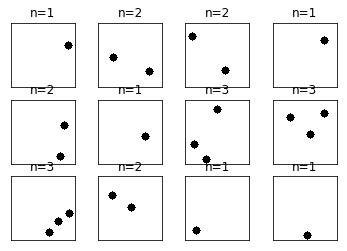

In [2]:
# input image dimensions and number of classes
img_rows, img_cols = 64, 64
num_classes = 3

# filename for loading the data from the NPZ files (NumPy compressed)
dataset = 'circles_same_radius'
same_shape_same_radius_fname = "/home/elena/eStep/XAI/Data/CountingShapes/" + dataset + "_60k.npz"


# load the set of images with the same type and same radius and split to train and test subsets
if os.path.isfile(same_shape_same_radius_fname): # already generated- just load
    print ("The file containing images of the same shape (circle) with same radius already exist!")
    # load from NPZ file for display
    images_train, _, images_test, labels_train, _, labels_test = si.load_split_data(same_shape_same_radius_fname)
    
    
    if K.image_data_format() == 'channels_first':
        images_train = images_train.reshape(images_train.shape[0], 1, img_rows, img_cols)
        images_test = images_test.reshape(images_test.shape[0], 1, img_rows, img_cols)

    print("Size of training data: ", np.shape(images_train), "and labels: ", np.shape(labels_train))
    print("Size of test data: ", np.shape(images_test), "and labels: ", np.shape(labels_test))
else: # missing data
    print ("The file containing images of the same shape (circle) with same radius does not exist!")
    print("Use the GenerateShapeImages notebook to generate the experimental data.") 
    
# plot random 12 of the train images
si.plot_12images(images_train, labels_train)

## Model
The next part evaluates the pretrained CNN.

In [3]:
# filename for model saving
same_shape_same_radius_model_fname = "/home/elena/eStep/XAI/Data/CountingShapes/model_circles_same_radius.h5"
# load the trained model

model = load_model(same_shape_same_radius_model_fname) 
print("Loaded model from disk")

Loaded model from disk


Formatting of the labels

In [4]:
# convert class vectors to binary class matrices
numerical_labels_test = labels_test
labels_test = np_utils.to_categorical(numerical_labels_test-1, num_classes=None)
print(labels_test)
print('labels_test shape:', labels_test.shape)

[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
labels_test shape: (6000, 3)


Evaluate on test images.

In [5]:
score = model.evaluate(images_test, labels_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.00023282187637717772
Test accuracy: 1.0


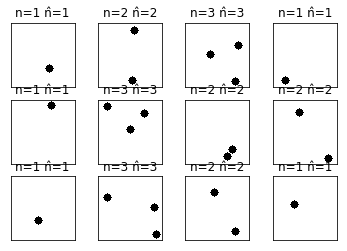

In [6]:
for i in range(12):
    n = int(np.random.randint(1, 3+1))
    shapes = [(0, 4) for _ in range(n)]
    img = si.generate_image(64, shapes, 0)    
    
    X = img[np.newaxis, :, :, np.newaxis].astype(np.float32)
    plt.subplot(3, 4, i+1) # 3 x 4 is not distorted, but 4 x 3 is!
    plt.imshow(img,cmap='binary')
    plt.xticks([])
    plt.yticks([])
    predictions = model.predict(X);
    #print(predictions)
    pred = np.argmax(predictions) + 1 # we subtracted 1 before
    #print(pred)
    plt.title('n=%d n̂=%d' % (n, pred))

plt.show()

## Analysis

Define a list of top analysis methods by preparing tuples containing the methods' string identifiers used by innvestigate.analyzer.create_analyzer(...), some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render.

In [7]:
# parameters
input_range = [0, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(images_test, input_range)
def input_postprocessing(X):
    #return revert_preprocessing(X) / 255
    return 1-X


noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input

# Configure analysis methods and properties
methods = [
    # NAME            OPT.PARAMS                POSTPROC FXN               TITLE

    # Show input
    ("input",         {},                       input_postprocessing,      "Input"),

    # Signal
    ("pattern.net",   {"pattern_type": "relu"}, mnistutils.bk_proj,        "PatternNet"), 


    # Interaction
    ("pattern.attribution",  {"pattern_type": "relu"}, mnistutils.heatmap,        "PatternAttribution"),
       
    ("deep_taylor.bounded",   {"low": input_range[0],"high": input_range[1]}, mnistutils.heatmap,        "DeepTaylor"),
    
    ("input_t_gradient",     {},                        mnistutils.heatmap,        "Input * Gradient"),
    
    ("integrated_gradients", {"reference_inputs": ri},  mnistutils.heatmap,        "Integrated Gradients"), 

    ("lrp.z",                {},                        mnistutils.heatmap,        "LRP-Z"),
]
    
print('Considered number of explainability methods:', len(methods)-1)

Considered number of explainability methods: 6


The main loop instantiates the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [8]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

path_to_analyzers = "/home/elena/eStep/XAI/Data/CountingShapes/Analyzers/" + dataset 


# Create analyzers.
analyzers = []
for method in methods:
    fname = os.path.join(path_to_analyzers, method[0]+'.npz')
    
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            neuron_selection_mode="index",
                                            **method[1])     
    
    if os.path.isfile(fname) :
        print("Analyzer", method[0], "exists! Loading...")
        analyzer = analyzer.load_npz(fname)
    else:
        print("Analyzer", method[0], " doesn't exist! Creating and possibly Training and [Saving]...")
        # Some analyzers require training.
        analyzer.fit(images_train, batch_size=256, verbose=1)
        if (method[0]=='pattern.net') or (method[0]=='pattern.attribution'):
            analyzer.save_npz(fname)
    
    analyzers.append(analyzer)


Analyzer input  doesn't exist! Creating and possibly Training and [Saving]...
Analyzer pattern.net exists! Loading...
Analyzer pattern.attribution exists! Loading...
Analyzer deep_taylor.bounded  doesn't exist! Creating and possibly Training and [Saving]...
Analyzer input_t_gradient  doesn't exist! Creating and possibly Training and [Saving]...
Analyzer integrated_gradients  doesn't exist! Creating and possibly Training and [Saving]...
Analyzer lrp.z  doesn't exist! Creating and possibly Training and [Saving]...


Analyze random set of tet images with the different analyzers on all output neurons:

--------------------------------------------------------------------------------
Image nr. 1791; prediction: 3 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

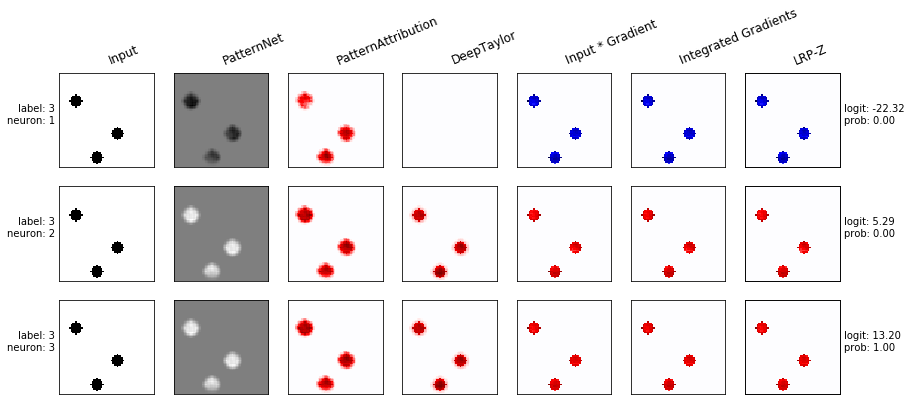

--------------------------------------------------------------------------------
Image nr. 1792; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

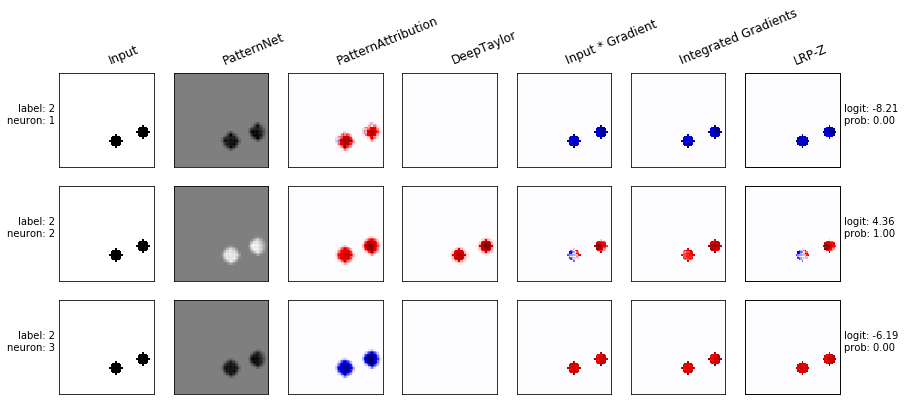

--------------------------------------------------------------------------------
Image nr. 1793; prediction: 3 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

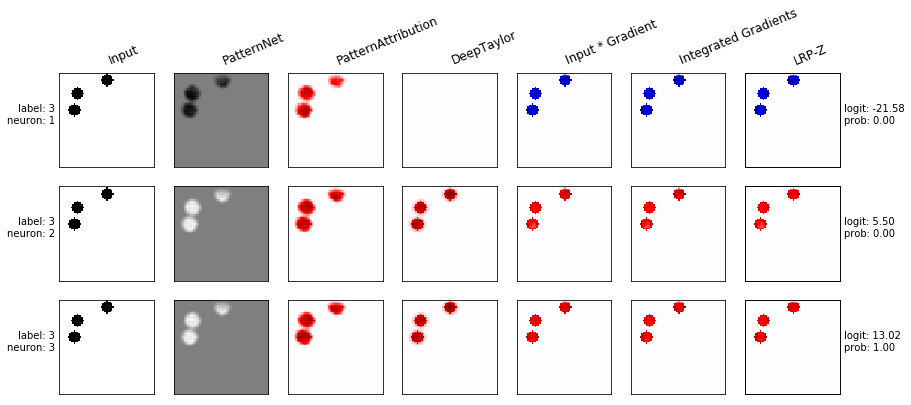

--------------------------------------------------------------------------------
Image nr. 1794; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

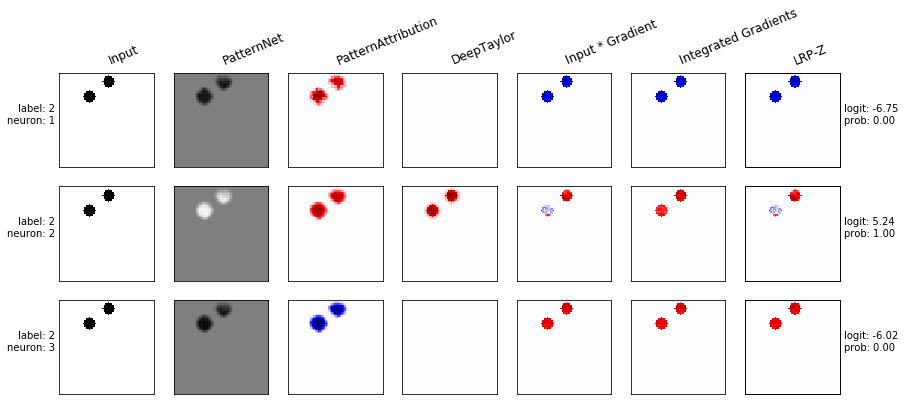

--------------------------------------------------------------------------------
Image nr. 1795; prediction: 1 
('1', '1', '1')


<Figure size 432x288 with 0 Axes>

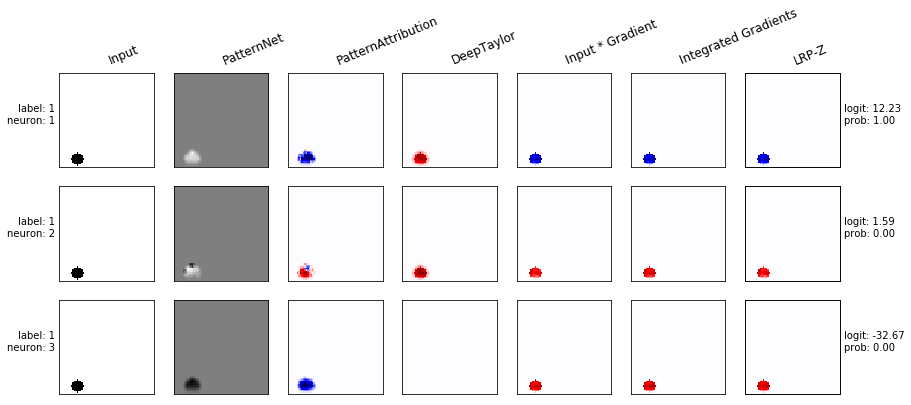

--------------------------------------------------------------------------------
Image nr. 1796; prediction: 1 
('1', '1', '1')


<Figure size 432x288 with 0 Axes>

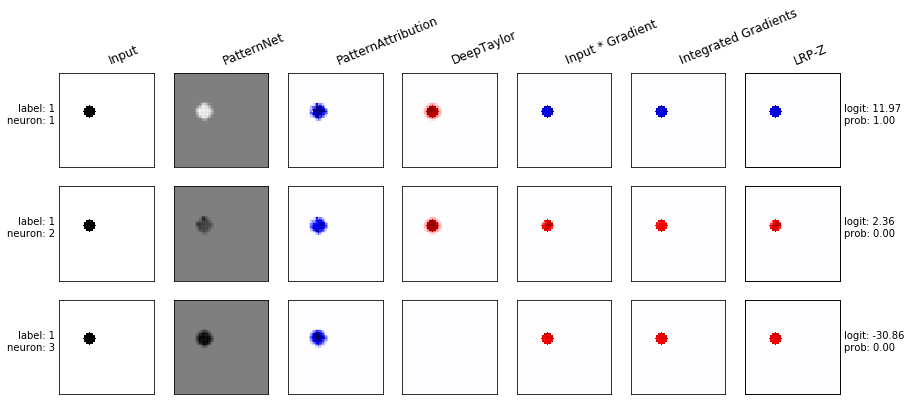

--------------------------------------------------------------------------------
Image nr. 1797; prediction: 3 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

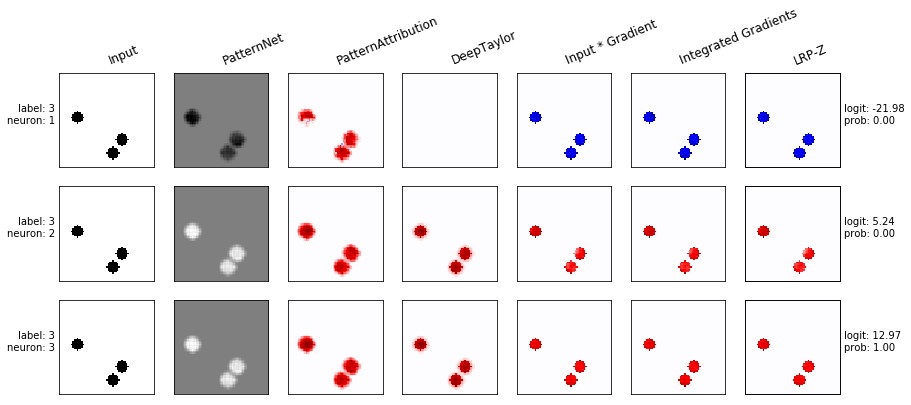

--------------------------------------------------------------------------------
Image nr. 1798; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

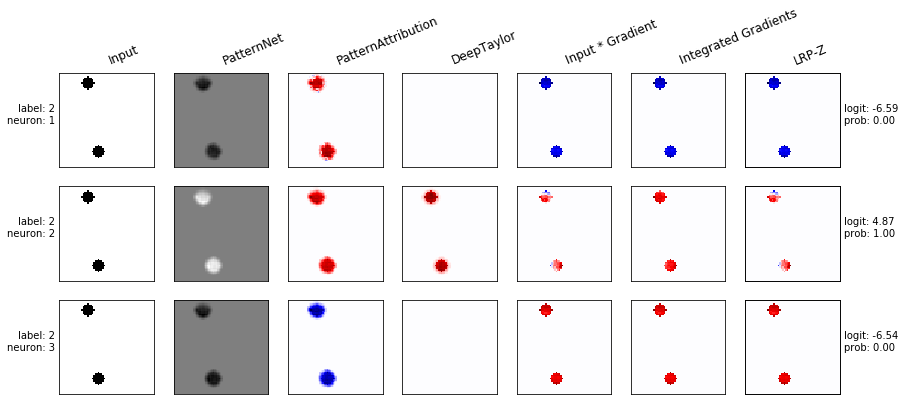

--------------------------------------------------------------------------------
Image nr. 1799; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

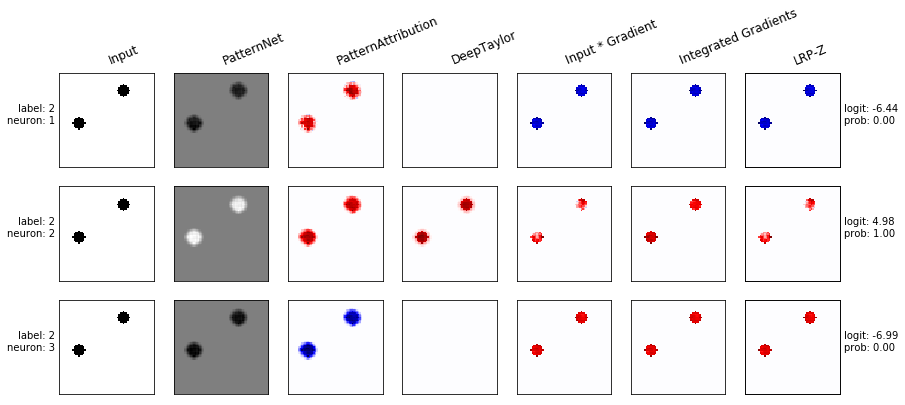

--------------------------------------------------------------------------------
Image nr. 1800; prediction: 1 
('1', '1', '1')


<Figure size 432x288 with 0 Axes>

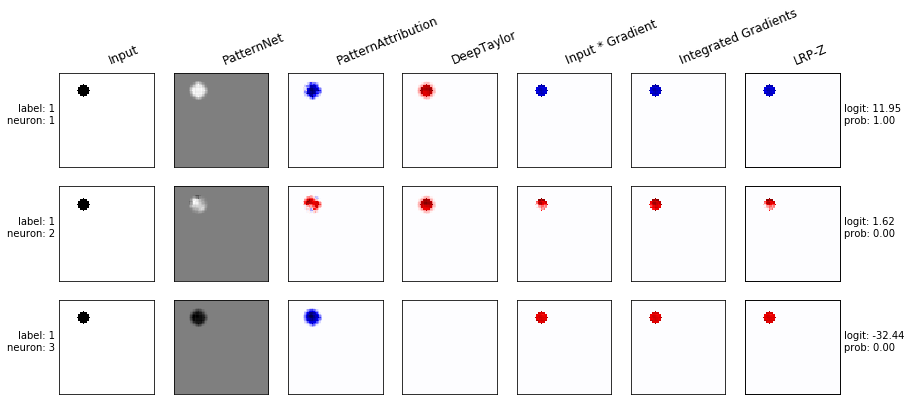

--------------------------------------------------------------------------------
Image nr. 1801; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

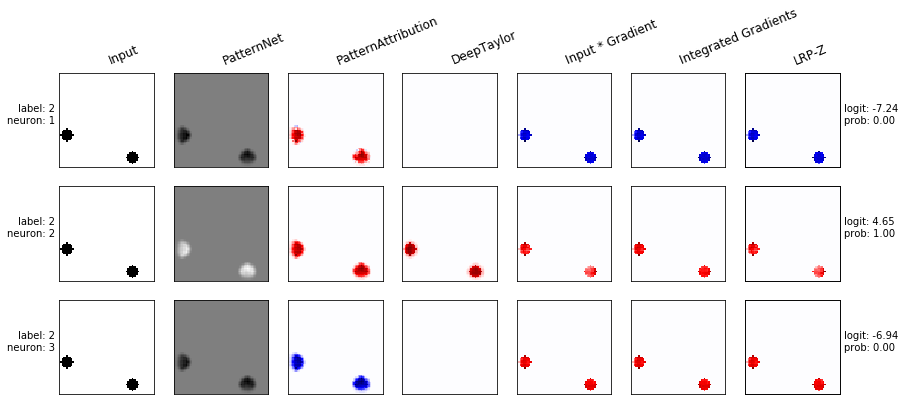

--------------------------------------------------------------------------------
Image nr. 1802; prediction: 3 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

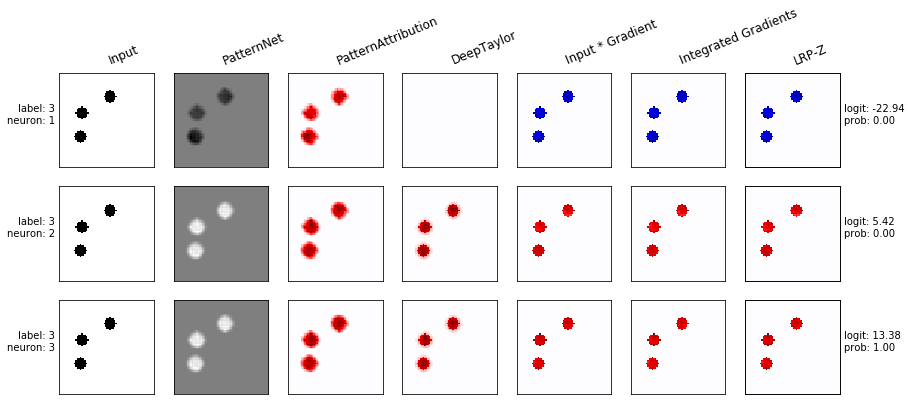

--------------------------------------------------------------------------------
Image nr. 1803; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

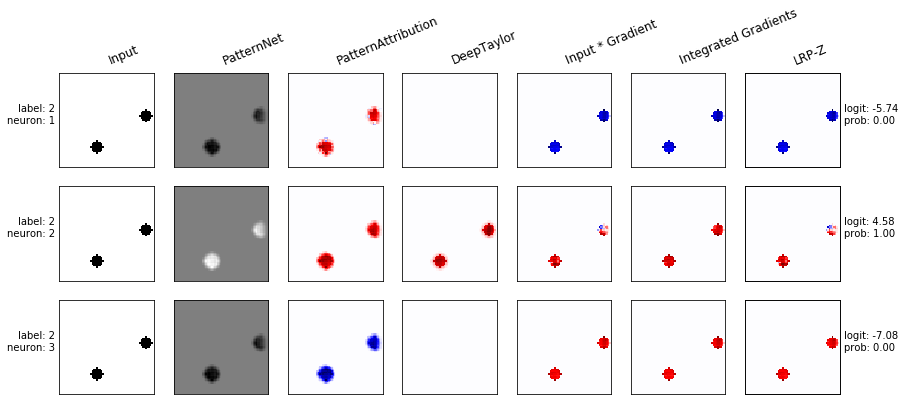

--------------------------------------------------------------------------------
Image nr. 1804; prediction: 3 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

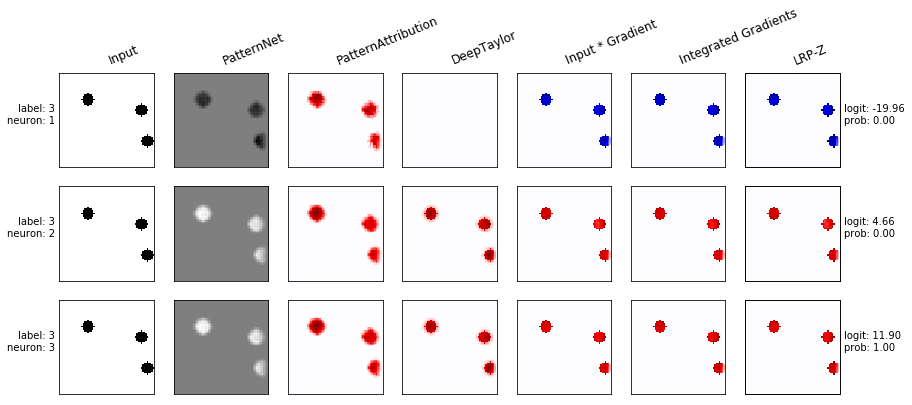

--------------------------------------------------------------------------------
Image nr. 1805; prediction: 3 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

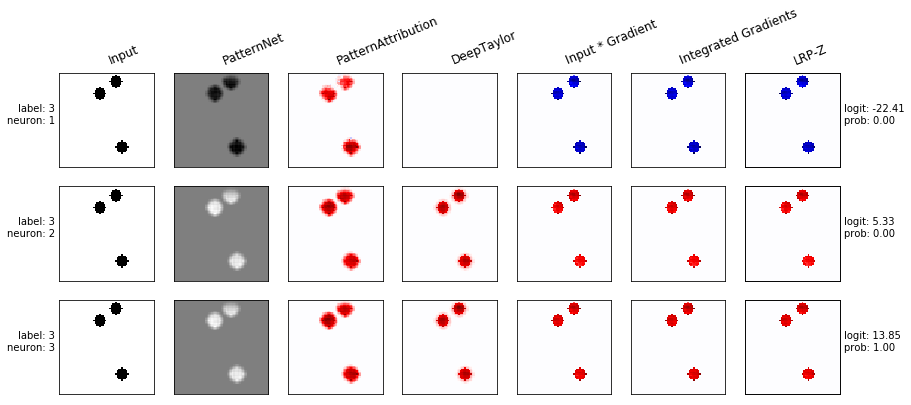

--------------------------------------------------------------------------------
Image nr. 1806; prediction: 1 
('1', '1', '1')


<Figure size 432x288 with 0 Axes>

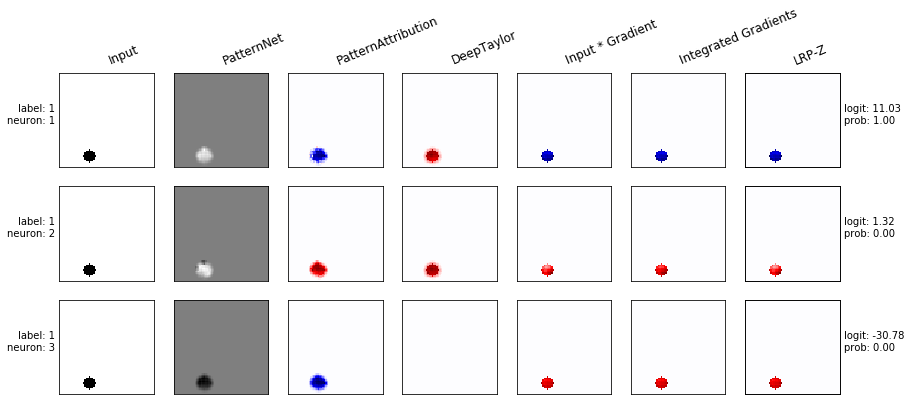

--------------------------------------------------------------------------------
Image nr. 1807; prediction: 3 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

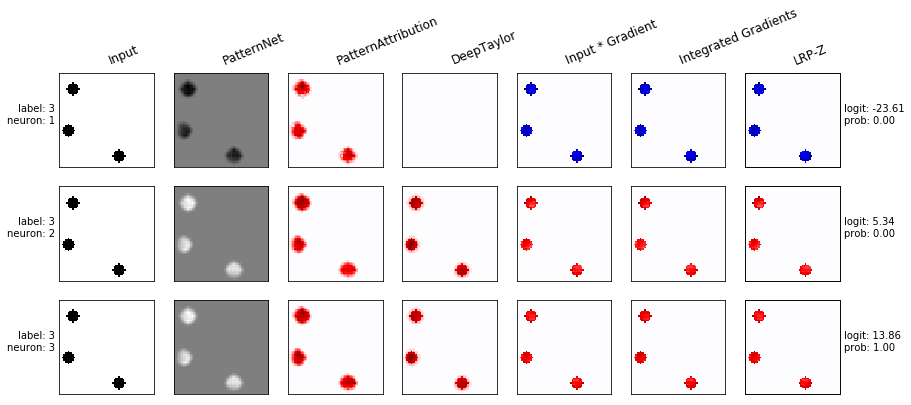

--------------------------------------------------------------------------------
Image nr. 1808; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

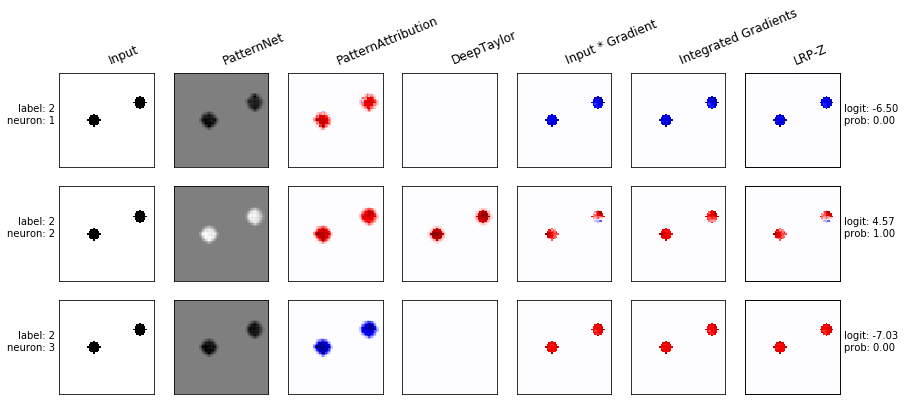

--------------------------------------------------------------------------------
Image nr. 1809; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

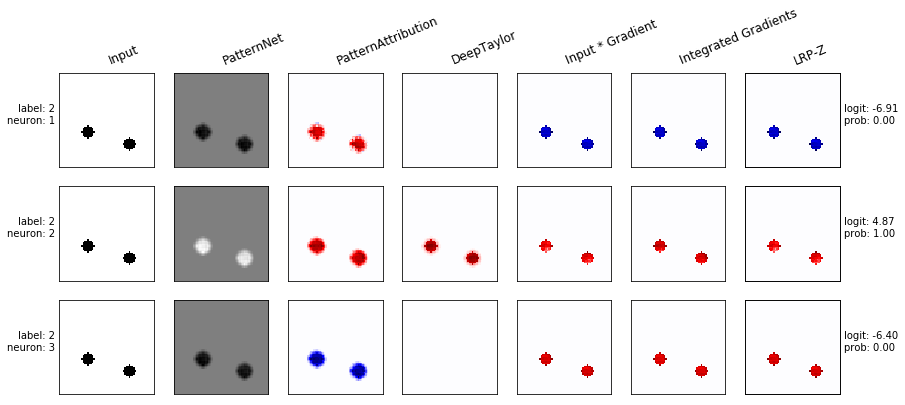

--------------------------------------------------------------------------------
Image nr. 1810; prediction: 3 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

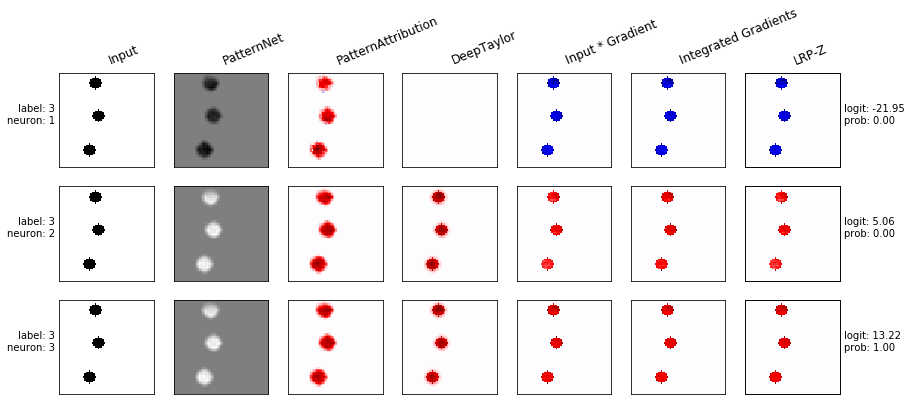

--------------------------------------------------------------------------------
Image nr. 1811; prediction: 3 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

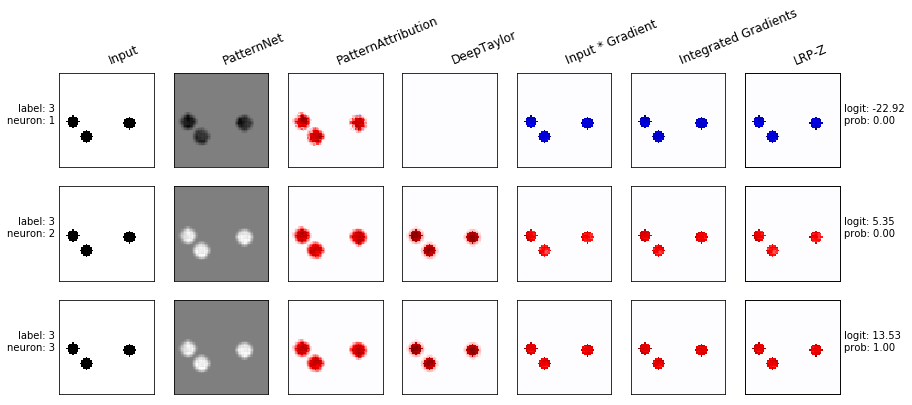

--------------------------------------------------------------------------------
Image nr. 1812; prediction: 1 
('1', '1', '1')


<Figure size 432x288 with 0 Axes>

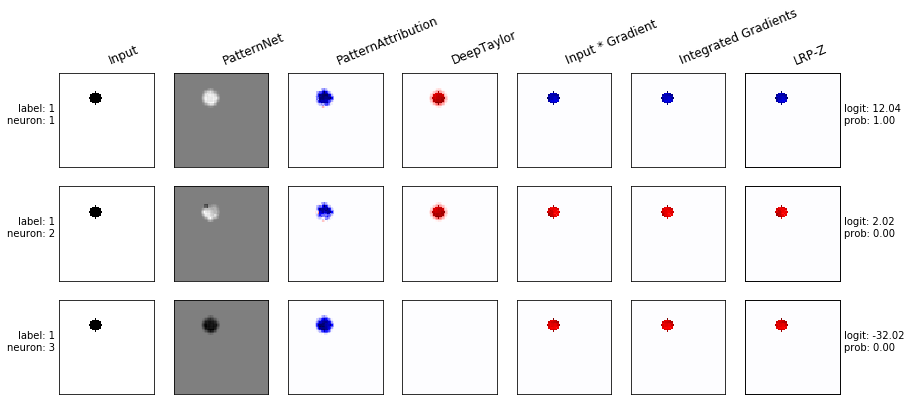

--------------------------------------------------------------------------------
Image nr. 1813; prediction: 3 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

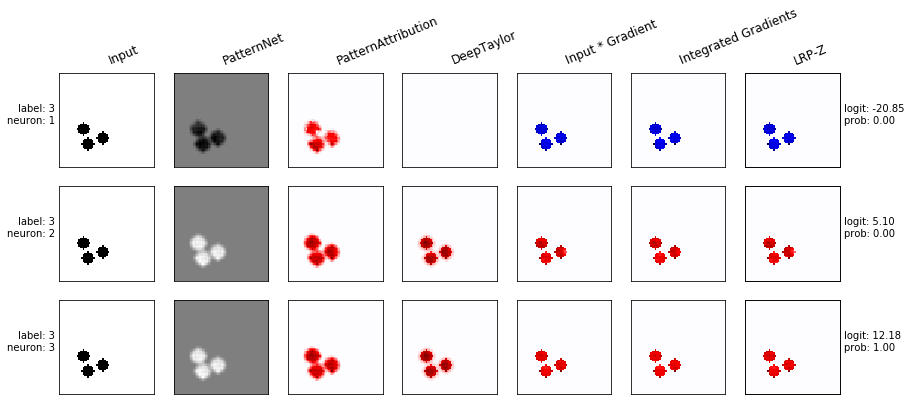

--------------------------------------------------------------------------------
Image nr. 1814; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

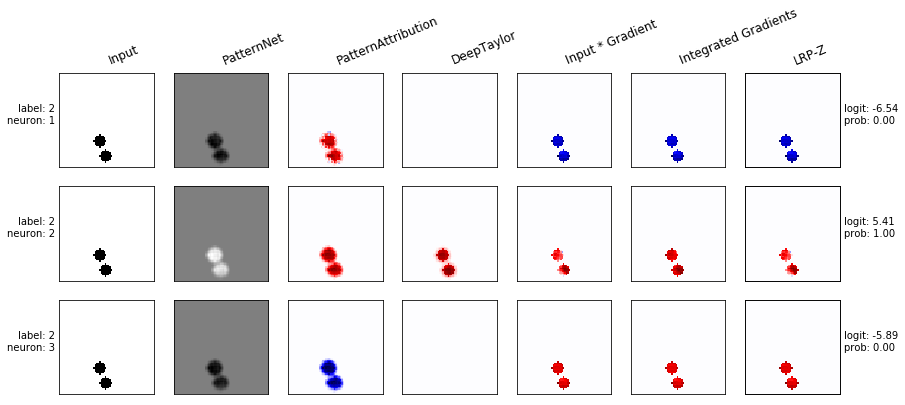

--------------------------------------------------------------------------------
Image nr. 1815; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

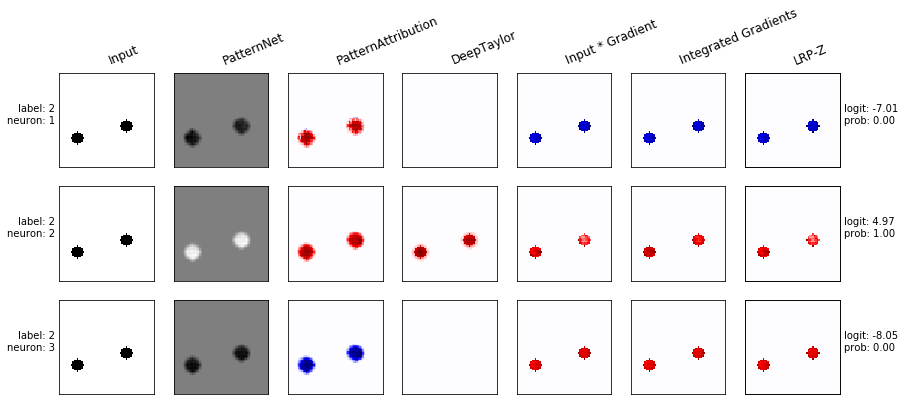

In [9]:
nim = len(labels_test)
ntim = 25
ind = int(np.random.randint(1,nim-ntim))

test_images = list(zip(images_test[ind:ind+ntim], numerical_labels_test[ind:ind+ntim]-1))
label_to_class_name = [str(i+1) for i in range(num_classes)]

for image_nr, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]

    analysis = np.zeros([num_classes, len(analyzers), 64, 64, 3])
    text = []

    for ii, output_neuron in enumerate([0, 1, 2]):
        # Predict final activations, probabilites, and label.
        presm = model_wo_softmax.predict_on_batch(x)[0]
        prob = model.predict_on_batch(x)[0]
        y_hat = prob.argmax()

        # Save prediction info:
        text.append(("%s" % label_to_class_name[y],    # ground truth label
                     "%.2f" % presm[output_neuron],    # pre-softmax logits
                     "%.2f" % prob[output_neuron],     # probabilistic softmax output  
                     "%s" % label_to_class_name[output_neuron]
                    ))
       

        for aidx, analyzer in enumerate(analyzers):
            # Analyze.
            a = analyzer.analyze(x, neuron_selection=output_neuron)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            a = mnistutils.postprocess(a)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            a = methods[aidx][2](a)
            # Store the analysis.
            analysis[ii, aidx] = a[0]

    print("-"*80)
    print("Image nr. {}; prediction: {} ".format(ind+image_nr, y_hat+1))
    # Prepare the grid as rectengular list
    grid = [[analysis[i, j] for j in range(analysis.shape[1])]
            for i in range(analysis.shape[0])]
    # Prepare the labels
    label, presm, prob, pred = zip(*text)
    print(label)
    row_labels_left = [('label: {}'.format(label[i]), 'neuron: {}'.format(pred[i])) for i in range(len(label))]
   # row_labels_right = []
    row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
    col_labels = [''.join(method[3]) for method in methods]

    # Plot the analysis.
    file_name = os.environ.get("PLOTFILENAME", None)
   # print(file_name)
    if file_name is not None:
        file_name = ".".join(file_name.split(".")[:-1])+("_%i" % output_neuron)+file_name.split(".")[-1]   
    n_rows = len(grid)
    n_cols = len(grid[0])
    figsize = (2*n_cols, 2*(n_rows+1))
    eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels, figsize=figsize, file_name=file_name)
